In [1]:
import numpy as np
import networkx as nx


from Simplex2Vec.Simplex2Vec import Simplex2Vec

# From NetworkX Graph

In [2]:
# Create a graph
G = nx.fast_gnp_random_graph(n=100, p=0.1, seed=20)

# Generate Hasse diagram and random walks
s2v = Simplex2Vec(G, n_walks=15, walk_length=10,  workers=2)  # keep p=q=1 to have the usual RW

# Embed nodes
model = s2v.fit()  # Any keywords acceptable by gensim.Word2Vec can be passed, `workers` is automatically passed from the Node2Vec constructor

Creating random walks: 100%|██████████| 12150/12150 [00:03<00:00, 3740.83it/s]


In [3]:
# Look for most similar nodes
model.wv.most_similar('2')  # Output node names are always strings

[('2-35-44', 0.9585344791412354),
 ('2-35', 0.9493824243545532),
 ('2-44', 0.9313633441925049),
 ('2-35-68', 0.9284526705741882),
 ('15-2-35', 0.8970949649810791),
 ('35-44', 0.8915023803710938),
 ('17-2-44', 0.8811018466949463),
 ('17-2', 0.8768243789672852),
 ('2-35-62', 0.8747244477272034),
 ('2-41', 0.8680779933929443)]

In [4]:
# Can also be made a one-liner
model = Simplex2Vec(G, n_walks=15, walk_length=10,  workers=2).fit()

Creating random walks: 100%|██████████| 12150/12150 [00:03<00:00, 3888.52it/s]


In [5]:
# Dump created hasse diagram to a pickle file
s2v.dump_hasse_diagram('hasse_diag.pkl')

### MODEL CAN BE SAVED WITH model.save(), NATIVELY FROM WORD2VEC

In [6]:
# Create new Simplex2Vec from dumped hasse diagram
s2v = Simplex2Vec.read_hasse_diagram('hasse_diag.pkl', n_walks=15)
model = s2v.fit()

model.wv.most_similar('2')

Creating random walks: 100%|██████████| 12150/12150 [00:08<00:00, 1501.46it/s]


[('2-44', 0.9288267493247986),
 ('2-35-68', 0.9205431938171387),
 ('2-35-44', 0.9184633493423462),
 ('2-35', 0.9164999127388),
 ('2-35-62', 0.8992202281951904),
 ('17-2', 0.8971463441848755),
 ('17-2-44', 0.881851077079773),
 ('2-72', 0.8778567314147949),
 ('2-35-72', 0.8726463317871094),
 ('15-2-35', 0.866547167301178)]

In [7]:
# Create external handle for hasse diagram
H = s2v.get_hasse_diagram(copy=False)

print(H is s2v.hasse)

True


In [8]:
# Create external deepcopy of hasse diagram
H = s2v.get_hasse_diagram()

print(H is s2v.hasse)

False


# From External Hasse Diagram

In [9]:
#Build hasse diagram externally

from Simplex2Vec.utils import read_simplex_json
from Simplex2Vec.simplex2hasse import simplex2hasse_LOadjusted

in_file = "./data/sociopatterns_facets/aggr_5min_cliques_InVS15.json"

data = read_simplex_json(in_file)

hasse_diag = simplex2hasse_LOadjusted(data, max_order=None)

Creating Hasse diagram: 100%|██████████| 7526/7526 [00:06<00:00, 1138.82it/s]


In [10]:
# build model from external hasse diagram
s2v = Simplex2Vec.from_hasse_diagram(hasse_diag, n_walks=1, walk_length=10)

Creating random walks: 100%|██████████| 7743/7743 [00:07<00:00, 1001.97it/s]


In [11]:
# limit order of imported hasse diagram
s2v = Simplex2Vec.from_hasse_diagram(hasse_diag, n_walks=1, walk_length=10, hasse_max_order=2)

Creating random walks: 100%|██████████| 6708/6708 [00:06<00:00, 986.47it/s] 


In [12]:
# warning if you try to set a limit higher than what is present in the external hasse diagram
hasse_diag = simplex2hasse_LOadjusted(data, max_order=2)
print()

s2v = Simplex2Vec.from_hasse_diagram(hasse_diag, n_walks=1, walk_length=10, hasse_max_order=3)

Creating Hasse diagram: 100%|██████████| 7526/7526 [00:01<00:00, 4002.41it/s]


/home/mottes/WorkInProgress/S2V_project/Simplex2Vec/Simplex2Vec/Simplex2Vec.py:97: UserWarning: No simplices of order bigger than 3 (MAX ORDER = 2). Maybe need to re-build Hasse diagram?
  warnings.warn(message, UserWarning)
Creating random walks: 100%|██████████| 6708/6708 [00:06<00:00, 966.83it/s] 


#### Note: The original hasse_diag graph is not modified by limiting the simplex order in the creation of the Simplex2vec object and can thus be reused.

# USE CASE

In [12]:
### EXAMPLE: create embeddings using increasingly higher orders without re-building hasse diag.


#Build hasse diagram externally

import numpy as np
import networkx as nx


from Simplex2Vec.Simplex2Vec import Simplex2Vec

from Simplex2Vec.utils import read_simplex_json
from Simplex2Vec.simplex2hasse import *

in_file = "./data/sociopatterns_facets/aggr_5min_cliques_InVS15.json"

data = read_simplex_json(in_file)

In [13]:
hasse_diag = simplex2hasse_proportional(data, max_order=None)

Creating Hasse diagram: 100%|██████████| 7526/7526 [00:02<00:00, 2914.42it/s]


In [14]:

for order in range(1,4):
    
    s2v = Simplex2Vec.from_hasse_diagram(hasse_diag, n_walks=1, walk_length=10, hasse_max_order=order)
    
    print('\nMAX ORDER = {}'.format(order))
    print(nx.info(s2v.get_hasse_diagram(copy=False)))
    
    #model = s2v.fit()


Creating random walks: 100%|██████████| 4491/4491 [00:03<00:00, 1168.86it/s]



MAX ORDER = 1
Name: 
Type: DiGraph
Number of nodes: 4491
Number of edges: 17096
Average in degree:   3.8067
Average out degree:   3.8067


Creating random walks: 100%|██████████| 6708/6708 [00:05<00:00, 1292.99it/s]



MAX ORDER = 2
Name: 
Type: DiGraph
Number of nodes: 6708
Number of edges: 30398
Average in degree:   4.5316
Average out degree:   4.5316


Creating random walks: 100%|██████████| 7395/7395 [00:05<00:00, 1345.44it/s]



MAX ORDER = 3
Name: 
Type: DiGraph
Number of nodes: 7395
Number of edges: 35894
Average in degree:   4.8538
Average out degree:   4.8538


In [ ]:
hasse_diag = simplex2hasse_LOadjusted(data, max_order=None)

In [13]:
for order in range(1,4):
    
    s2v = Simplex2Vec.from_hasse_diagram(hasse_diag, n_walks=1, walk_length=10, hasse_max_order=order)
    
    print('\nMAX ORDER = {}'.format(order))
    print(nx.info(s2v.get_hasse_diagram(copy=False)))
    
    #model = s2v.fit()
    

Creating random walks: 100%|██████████| 4491/4491 [00:04<00:00, 988.00it/s] 



MAX ORDER = 1
Name: 
Type: Graph
Number of nodes: 4491
Number of edges: 8548
Average degree:   3.8067


Creating random walks: 100%|██████████| 6708/6708 [00:06<00:00, 984.16it/s] 



MAX ORDER = 2
Name: 
Type: Graph
Number of nodes: 6708
Number of edges: 15199
Average degree:   4.5316


Creating random walks: 100%|██████████| 7395/7395 [00:07<00:00, 982.20it/s] 



MAX ORDER = 3
Name: 
Type: Graph
Number of nodes: 7395
Number of edges: 17947
Average degree:   4.8538


# Weighted distance matrix of brain data

In [1]:
import numpy as np
import networkx as nx

from Simplex2Vec.Simplex2Vec import Simplex2Vec
from Simplex2Vec.utils import read_data_HCP
from os.path import join as osjoin

In [2]:
ICAOrder = 15
data_path = "./data/HCP_Netmats/ICA" + str(ICAOrder) 
#data_path = "/home/jcwbillings/Documents/complexity72h/doublenegroni/data/HCP_PTN1200/netmats_3T_HCP1200_MSMAll_ICAd" + str(ICAOrder) + "_ts2/netmats/3T_HCP1200_MSMAll_d" + str(ICAOrder) + "_ts2"
filename = osjoin(data_path, 'Mnet2.pconn.nii')

data = read_data_HCP(filename)              
# HCP ICA data are delivered as gaussian distributed correlation z-stats. Proceed accordingly
# Take caution for thresholds less than the 50th percentile, self-loops and negative correlations will be included

In [3]:
s2v = Simplex2Vec.from_graph(data, 
                               threshold=np.percentile(data,55), 
                               n_walks=10, 
                               walk_length=20, 
                               workers=1,
                               hasse_max_order = 3)

Creating random walks: 100%|██████████| 1110/1110 [00:01<00:00, 886.29it/s]


In [4]:
model=s2v.fit()

1110


In [22]:
model=s2v.refit()

Creating random walks: 100%|██████████| 1110/1110 [00:01<00:00, 850.66it/s]


1110


In [23]:
from ast import literal_eval
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
import matplotlib.pyplot as plt
import matplotlib.cm as cm

X = []
X_labels = []
X_bNodes = []
X_sizes = []
for u in model.wv.vocab.keys():
    X.append(model[u])
    #X_labels.append("".join(list(u)))
    X_labels.append(u)
    X_bNodes.append(literal_eval(X_labels[-1]))
    X_sizes.append(np.size(X_bNodes[-1]))


X_transform = TSNE(n_components=2).fit_transform(X)

/home/jcwbillings/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


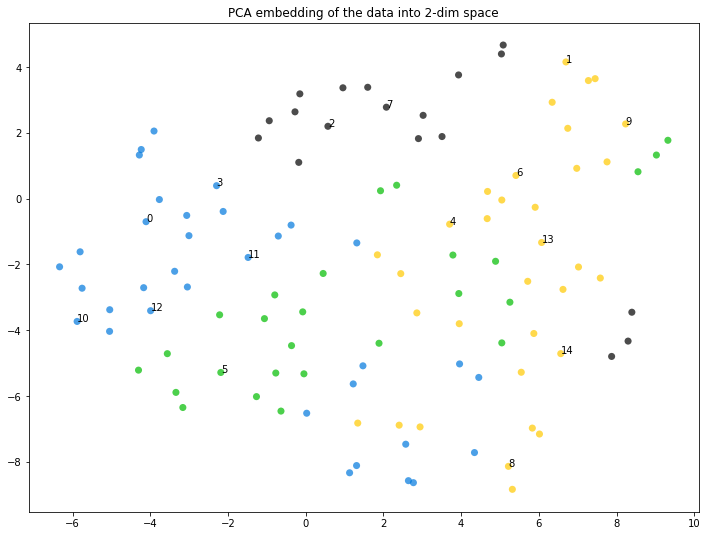

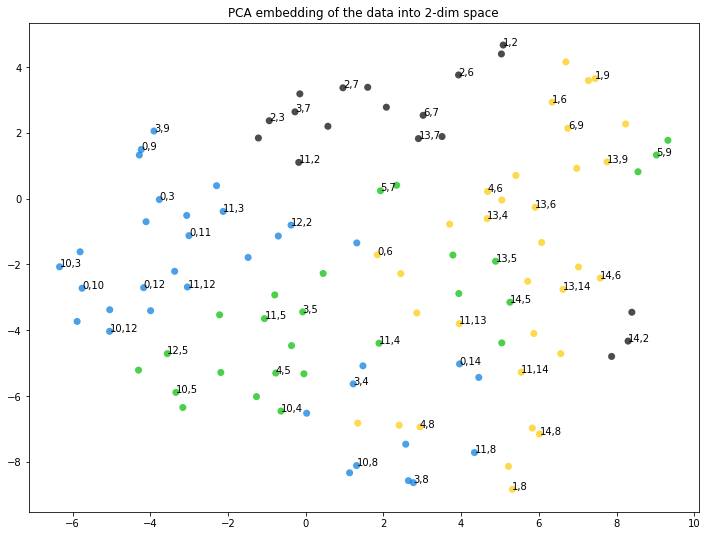

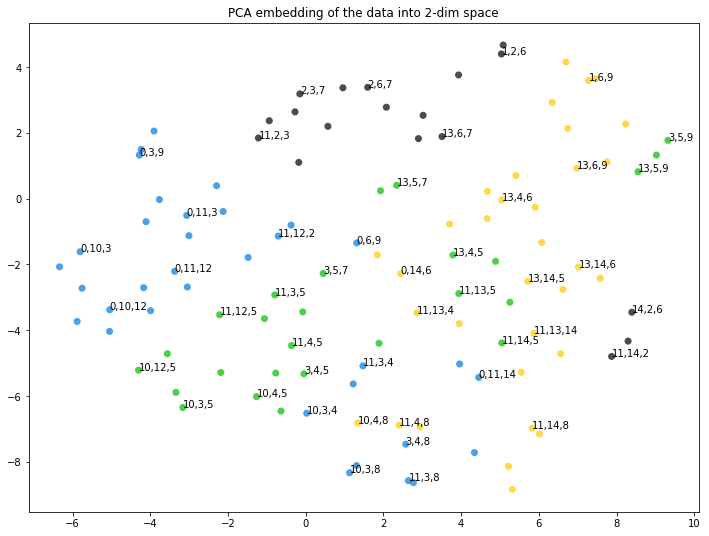

In [24]:
n_clusters = 4

clusterer = KMeans(n_clusters=n_clusters)
cluster_labels = clusterer.fit_predict(X)
clusterer_for_labels = KMeans(n_clusters=n_clusters, random_state=10)
clusterer_for_labels_centers = clusterer_for_labels.fit_predict(X_transform)

colors2 = cm.nipy_spectral(np.arange(n_clusters) / n_clusters)

for hh in range(max(X_sizes)):

    plt.figure(figsize = (12,9))
    ax = plt.gca()
    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax.scatter(*zip(*X_transform), marker='o', s=50, lw=0, alpha=0.7,
                     c = colors, edgecolor='k')
    
    for i, label in enumerate(X_labels):
        x,y = X_transform[i]
        if X_sizes[i]==hh+1:
            ax.annotate(label, (x,y))
    ax.set_title("PCA embedding of the data into 2-dim space")
    plt.show()